# Deep kernel learning for data reconstruction and automated experiment

- Made by Maxim Ziatdinov (January 2022), https://scholar.google.com/citations?user=YnSdOoUAAAAJ
- STEM EELS Data by Kevin Roccapriore, https://scholar.google.com/citations?hl=en&user=PJwlbBIAAAAJ
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!

This DKL workflow was implemented on the operational NION microscope via SWIFT interface. The results were published as https://onlinelibrary.wiley.com/doi/full/10.1002/advs.202203422


**Basic principles:**
The DKL can be viewed as an extension of Gaussian process (GP) for high-dimensional data. Hence, we first briefly overview the standard GP. GP is a powerful tool for reconstructing with quantified uncertainty an unknown  (“black-box”) function  over a low-dimensional parameter space. Formally, given a set of observed data points $(x_i, y_i)_{i=1, ..., N}$ and assuming normally distributed observation noise $𝜀$, the GP can be defined as

$$y_i= f(x_i) + 𝜀_i$$
$$f ∼ MVN(0; K(x_i, x_j))$$

where $MVN$ stands for Multivariate Normal Distribution, $K$ is a kernel function,  and $f(x)$ is a "black-box" function we try to reconstruct. The functional form of the kernel $K$ is chosen prior to the experiment, and its hyperparameters are inferred from the observations using either Markov chain Monte Carlo methods or stochastic variational inference. 

Once the GP model is trained, we can use it to make a probabilistic prediction on new inputs. Specifically, the predictive mean and covariance on the new data $X_*$ are given by

$$𝜇_*=K(X_*,X|𝜃)K(X,X|𝜃)^{-1}y$$
$$𝛴_*=K(X_*,X_*|𝜃)-K(X_*,X|𝜃)K(X,X|𝜃)^{-1}K(X,X_*|𝜃)$$

where 𝜃 are learned GP kernel parameters. Note that we absorbed model noise into the computation of kernel function. The predictive uncertainty is given by the square root of the diagonal elements of the covariance matrix $U_*=\sqrt{\text{diag}(𝛴_*)}$.

The GP predictive mean and uncertainty can then be used to derive an acquisition function for selecting the next point to measure. Depending on the form of acqusition function, this can be referred to as active learning (discovering the overall data distribution) or Bayesian optimization (identifying global maximum or minimum). Here, we will refer to both of them as "active learning."

A significant limitation of the standard GP (and GP-based active learning) is that it does not scale well with the dimensionality of the parameter space. Another limitation is that the standard GP
does not, strictly speaking, learn representations of data which precludes us from using information from different experimental modalities to assist in selecting the next measurement point.

To address these issues, we have adapted a [deep kernel learning](https://arxiv.org/abs/1511.02222) (DKL) approach. DKL can be understood as a hybrid of deep neural network (DNN) and GP. The DNN serves as a feature extractor that allows reducing the complex high-dimensional features to low-dimensional descriptors on which a standard GP kernel operates. The parameters of DNN and GP kernel are inferred jointly in an end-to-end fashion. Practically, the DKL training inputs are usually patches from an (easy-to-acquire) structural image over a large field of view, and training targets represent a physical property of interest derived from the (hard-to-acquire) spectra measured in those patches. The DKL output on the new inputs (image patches for which there are no measured spectra) is the expected property value and associated uncertainty, which can be used to derive the next measurement point in the automated experiments. 

Formally, we define a deep kernel as

$$k_{DKL}(x_i,x_j|w,𝜃)=k_{base}(g(x_i|w),g(x_j|w)|𝜃)$$

where $g$ is a neural network with weights $w$ and $k_{base}$ is a standard GP kernel. The parameters of neural network and GP base
kernel are learned simultaneously via Markov chain Monte Carlo sampling techniques or a stochastic variational inference. The trained DKL model is then used for obtaining predictive mean and uncertainty and deriving the acquisition function the same way as for the standard GP.

GPax package has the fully Bayesian DKL (weights of neural network and GP hyperparameters are inferred using Hamiltonian Monte Carlo) and the Variational Inference approximation of DKL, viDKL. The fully Bayesian DKL can provide an asymptotically exact solution but is too slow for most automated experiments. Hence, for the latter, we use the viDKL.

# Installation

In [ ]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 68.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have 

In [ ]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

filterwarnings("ignore", module="haiku._src.data_structures")

# Prepared data

Here, we download the pre-aquired Electron Energy Loss Spectroscopy (EELS) data from the standard hyperspectral measurement. Generally, it is a good idea to build and test workflows on such data sets. That said, note that on real microscope we have much richer spectrum of possible experiments (e.g. we ar enot constarined by the number of pixels in strucutral image - we can always aquire more).

Download training data:

In [ ]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [ ]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra)



In [ ]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

/usr/local/lib/python3.10/dist-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 93))

Normalize data:

In [ ]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

# Define scalarizer
Next, we select a scalarizer function that will convert a measured spectrum into a scalar physical descriptor. The scalarizer defines the measure of physical interest to the response and acts as a reward towards the specific behavior in the experiment. The scalarizer can be created in almost unlimited number of ways. For example, it can be based
on the gross characteristic of the spectrum, such as area under curve, integrated intensity within certain energy range, area or width of hysteresis loop, etc. It can incorporate the physical model and physics-based analysis, for example converting predicted spectrum to specific materials parameters. It can be based on hybrid criteria defined via combinations of functional fits, decision trees, etc. Finally, it can be crowd sourced – if the neural network has been trained by human labelled data, or other form of expert system can be used. Ultimately however, the scalarizer should define the measure of physical interest much like the human operator would do.

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of the most prominent plasmonic peak, but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First, let's do it for a single spectrum:

25 0.2826059331244979


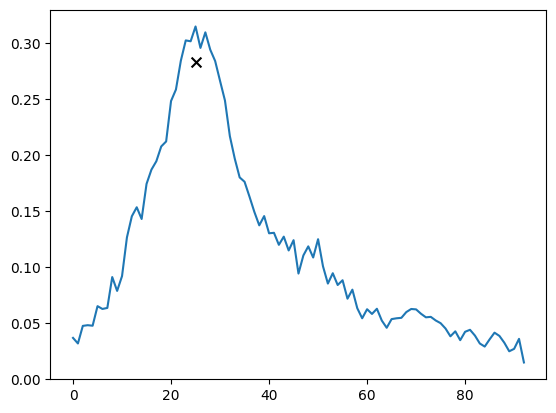

In [ ]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Now create scalarizer for all the data:

In [ ]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate. This defines our "ground truth" image, i.e. what we would have found if we run experiment everywhere (we did)

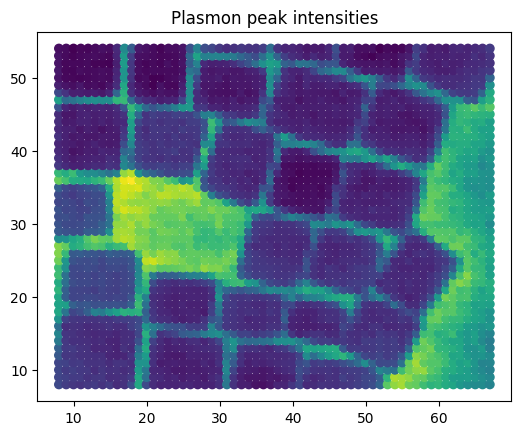

In [ ]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')

# Reconstruction from partial data: part of the image
Here we demonstrate how to use DKL to learn a correlative structure-property relationship from a relatively small number of image-(scalarized)spectrum pairs and then use the trained model to predict a targeted physical property for the entire image space.

Prepare data:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Split the data in such a way that we use only a relatively small part of data (to the left of the vertical dashed line in the figure below) to train a DKL model and then use the trained model to make a prediction of the "unmeasured" plasmon peak values (the part to the right of the vertical dashed line):

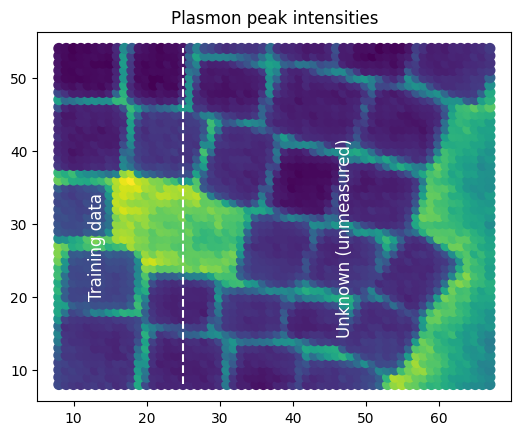

In [ ]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

_, ax = plt.subplots(dpi=100)
ax.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax.text(split_ // 2, 20, 'Training data', c='w', size=12, rotation=90)
ax.text((split_ + indices[:, 1].max()) // 2, 15, 'Unknown (unmeasured)', c='w', size=12, rotation=90)
ax.set_title('Plasmon peak intensities');
ax.set_aspect('equal')

Initialize and train a DKL model:

In [ ]:
data_dim = X_train.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:04<00:00, 21.08it/s, init loss: 21019.9002, avg. loss [96-100]: 18322.8905]



Inferred GP kernel parameters
k_length         [25.246  17.7663]
k_scale          0.1544
noise            0.011600000000000001


Use the trained model to make a probabilsitic prediction for all the image patches:

In [ ]:
mean, var = dkl.predict(key2, X)

Visualize predictive mean and uncertainty:

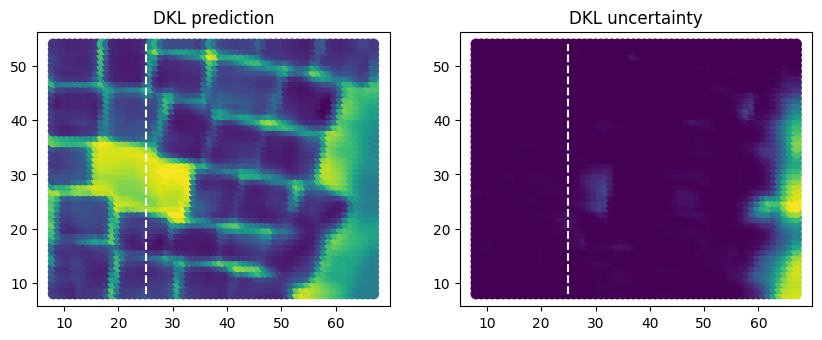

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), dpi=100)
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax1.set_title("DKL prediction")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax2.set_title("DKL uncertainty")
ax1.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
for _ax in fig.axes:
    _ax.set_aspect('equal')

We can also visualize the latent/embedding space:

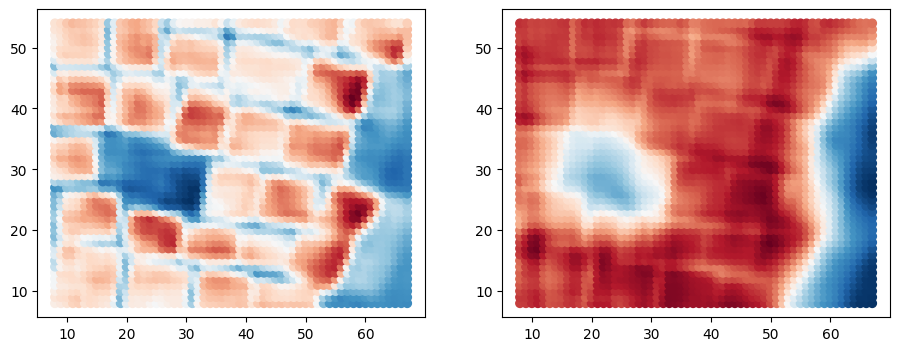

In [ ]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

# Reconstruction from partial data: random sampling

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

In [ ]:
indices_all.shape

(2820, 2)

In [ ]:
import random

fraction = 0.07

def select_random_data(array):
    num_rows, num_cols = array.shape
    num_elements = int(num_rows * fraction)
    random_indices = random.sample(range(num_rows), num_elements)
    return random_indices

197


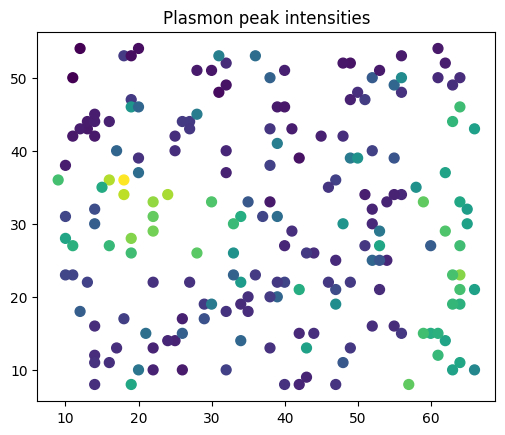

In [ ]:
random_indices = select_random_data(indices_all)
print(len(random_indices))

X_train = X[random_indices]
y_train = y[random_indices]
indices_train = indices_all[random_indices]

_, ax = plt.subplots(dpi=100)
#ax.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=peaks_all[random_indices])
ax.set_title('Plasmon peak intensities');
ax.set_aspect('equal')

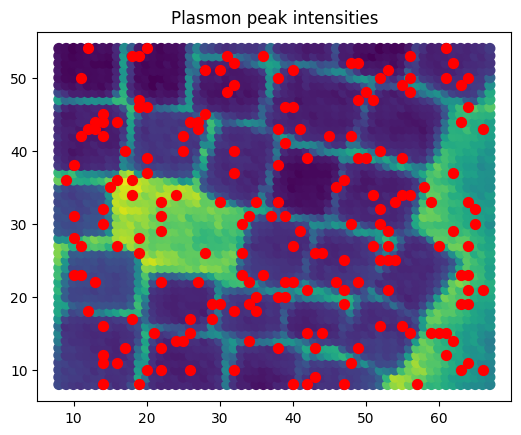

In [ ]:
_, ax = plt.subplots(dpi=100)
ax.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c='r')
ax.set_title('Plasmon peak intensities');
ax.set_aspect('equal')

In [ ]:
data_dim = X_train.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=1000, step_size=0.05)

100%|██████████| 1000/1000 [00:06<00:00, 166.52it/s, init loss: 20353.9629, avg. loss [951-1000]: 18950.2566]



Inferred GP kernel parameters
k_length         [38.0862 30.6843]
k_scale          0.1703
noise            0.0022


In [ ]:
mean, var = dkl.predict(key2, X)

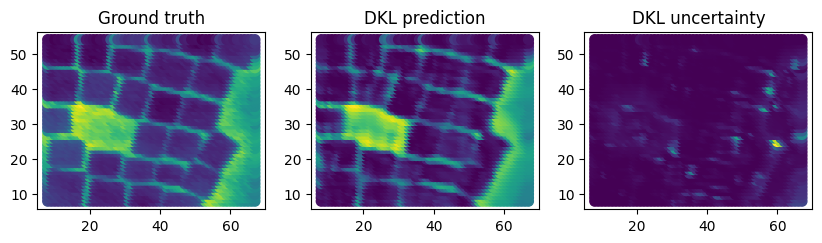

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4.5), dpi=100)
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
for _ax in fig.axes:
    _ax.set_aspect('equal')

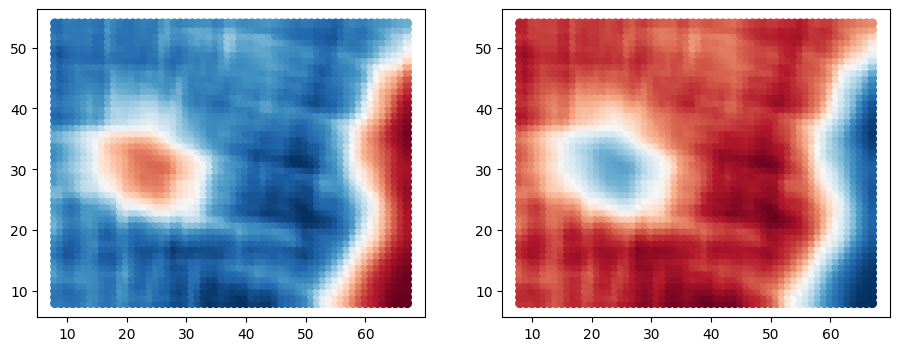

In [ ]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

In this section, experiment with the DKL reconstruction for random sampling. Rather impressively, it can reconstruct for ~1% of sampling points, well beyond the simple GP. Of course, in this case our ground truth image is very close to scalarizer, so it is unsurprising - but the same will be true for much more ocmplex data.

# Active learning
Now we are going to use DKL to actively learn (local) structures where a particular physical behavior or property (here, plasmon resonance peak) is maximized. Starting with just a few "measured" point, we use DKL to obtain predictive mean and variance for our property of interest over the entire parameter space, and then use them to compute the upper confedence bound (UCB) acquisition function for sampling the next measurement point.

Prepare the data

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Get the initial measurements aka training points. Here ```X_measured``` are the already measured points, that is, the image patches for which there are measured spectra, whose scalarized values are stored in ```y_measured```. The ```X_unmeasured``` are unmeasured points, that is, image patches for which there are yet no measured spectra. 

In [ ]:
# use only 0.02% of grid data points as initial training points
(X_measured, X_unmeasured, y_measured, y_unmeasured,
  indices_measured, indices_unmeasured) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=1)
  
seed_points = len(X_measured)

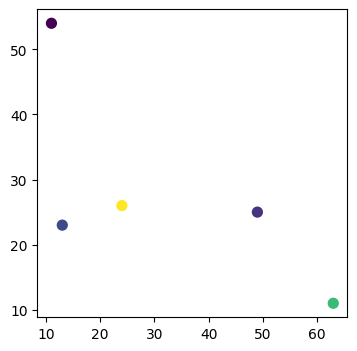

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_measured[:, 1], indices_measured[:, 0], s=50, c=y_measured)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/80


100%|██████████| 100/100 [00:01<00:00, 58.80it/s, init loss: 20124.5998, avg. loss [96-100]: 19061.5936]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2994
noise            0.1452


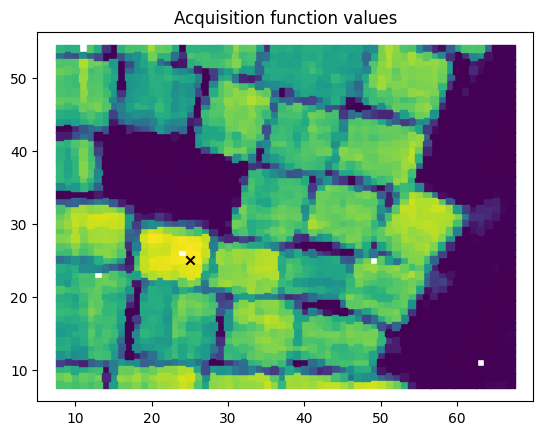

2/80


100%|██████████| 100/100 [00:01<00:00, 55.70it/s, init loss: 20126.0083, avg. loss [96-100]: 19062.0954]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3185
noise            0.1395


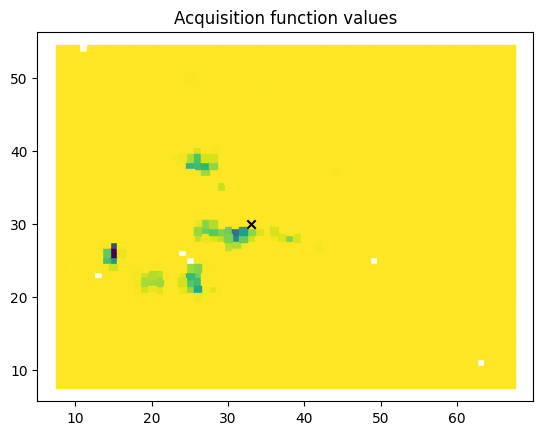

3/80


100%|██████████| 100/100 [00:01<00:00, 51.02it/s, init loss: 20127.3757, avg. loss [96-100]: 19062.2404]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3296
noise            0.1231


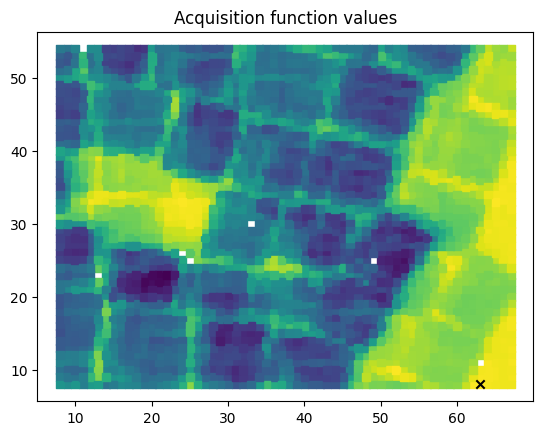

4/80


100%|██████████| 100/100 [00:01<00:00, 58.45it/s, init loss: 20128.6647, avg. loss [96-100]: 19062.1365]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33290000000000003
noise            0.10550000000000001


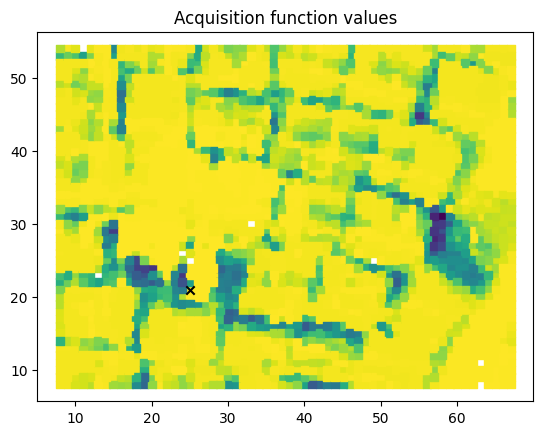

5/80


100%|██████████| 100/100 [00:02<00:00, 48.58it/s, init loss: 20129.9213, avg. loss [96-100]: 19062.3020]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3216
noise            0.10210000000000001


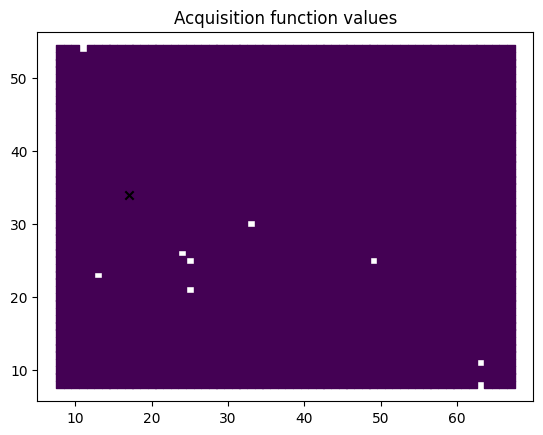

6/80


100%|██████████| 100/100 [00:01<00:00, 50.97it/s, init loss: 20131.3796, avg. loss [96-100]: 19062.9604]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33630000000000004
noise            0.1082


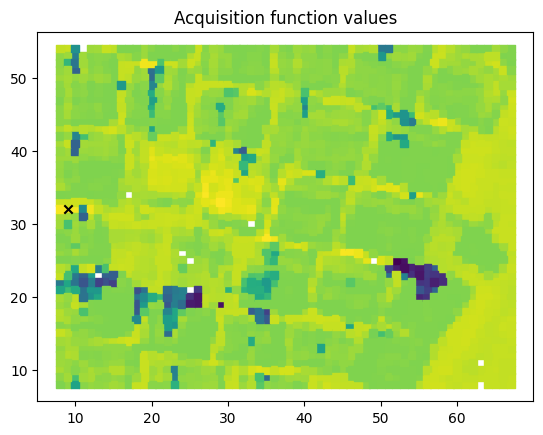

7/80


100%|██████████| 100/100 [00:01<00:00, 53.18it/s, init loss: 20132.6486, avg. loss [96-100]: 19062.9755]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32930000000000004
noise            0.1017


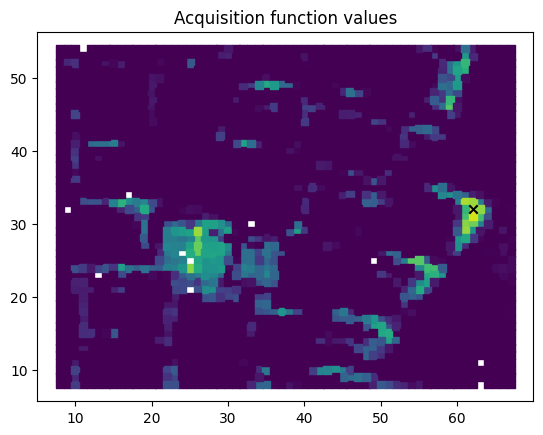

8/80


100%|██████████| 100/100 [00:01<00:00, 56.98it/s, init loss: 20134.0015, avg. loss [96-100]: 19062.8774]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3336
noise            0.0937


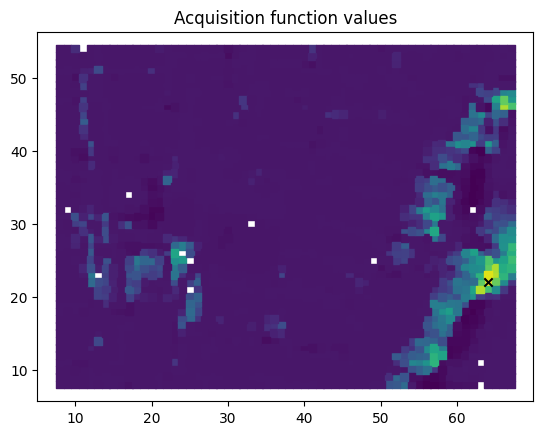

9/80


100%|██████████| 100/100 [00:02<00:00, 46.94it/s, init loss: 20135.3050, avg. loss [96-100]: 19062.9871]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.34090000000000004
noise            0.0906


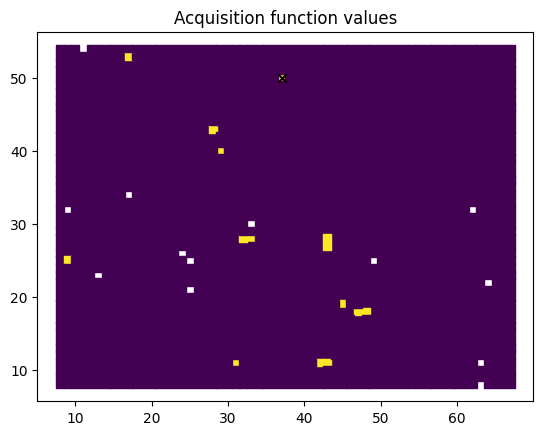

10/80


100%|██████████| 100/100 [00:02<00:00, 41.76it/s, init loss: 20136.6187, avg. loss [96-100]: 19062.6985]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.34090000000000004
noise            0.0833


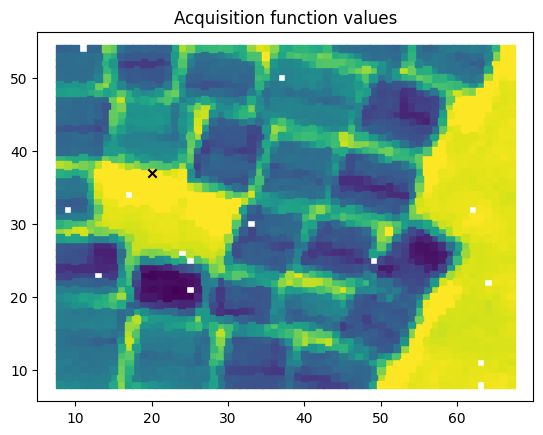

11/80


100%|██████████| 100/100 [00:01<00:00, 54.44it/s, init loss: 20137.9123, avg. loss [96-100]: 19062.4322]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3385
noise            0.0779


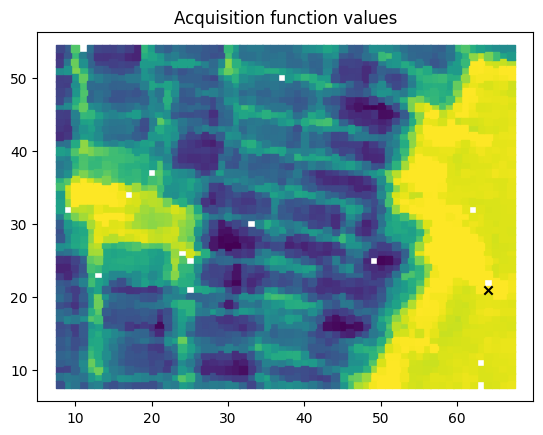

12/80


100%|██████████| 100/100 [00:01<00:00, 57.61it/s, init loss: 20139.1462, avg. loss [96-100]: 19062.3336]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.34290000000000004
noise            0.0748


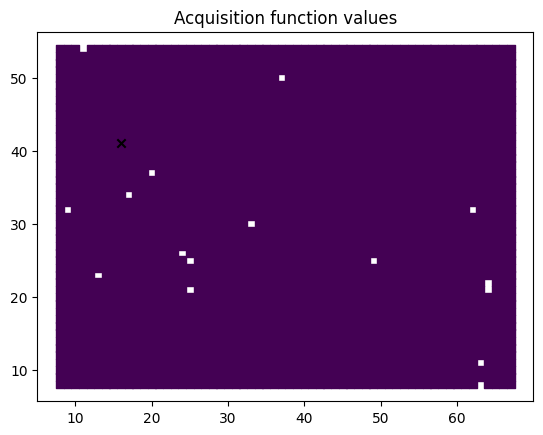

13/80


100%|██████████| 100/100 [00:01<00:00, 53.07it/s, init loss: 20140.3947, avg. loss [96-100]: 19062.6839]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33540000000000003
noise            0.0772


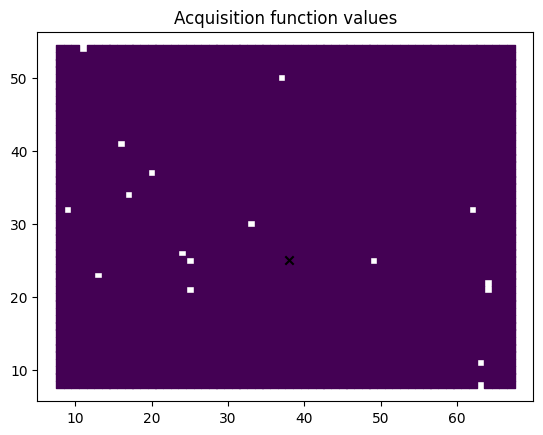

14/80


100%|██████████| 100/100 [00:02<00:00, 36.65it/s, init loss: 20141.6553, avg. loss [96-100]: 19062.7857]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3299
noise            0.07680000000000001


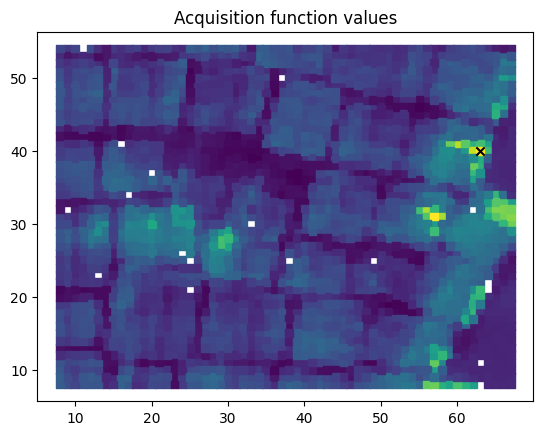

15/80


100%|██████████| 100/100 [00:02<00:00, 44.32it/s, init loss: 20143.0094, avg. loss [96-100]: 19062.5511]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3327
noise            0.0736


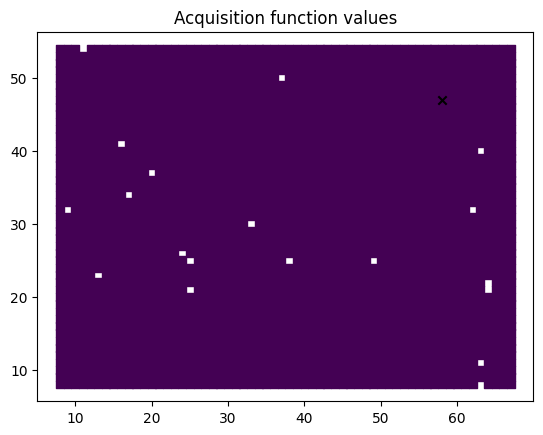

16/80


100%|██████████| 100/100 [00:01<00:00, 51.90it/s, init loss: 20144.1749, avg. loss [96-100]: 19062.5838]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3282
noise            0.0729


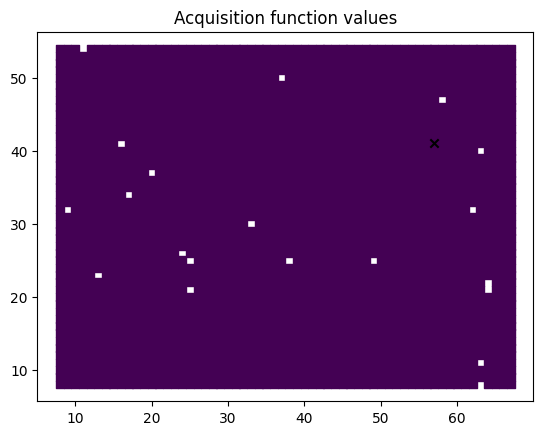

17/80


100%|██████████| 100/100 [00:01<00:00, 50.67it/s, init loss: 20145.3508, avg. loss [96-100]: 19062.7415]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3235
noise            0.0731


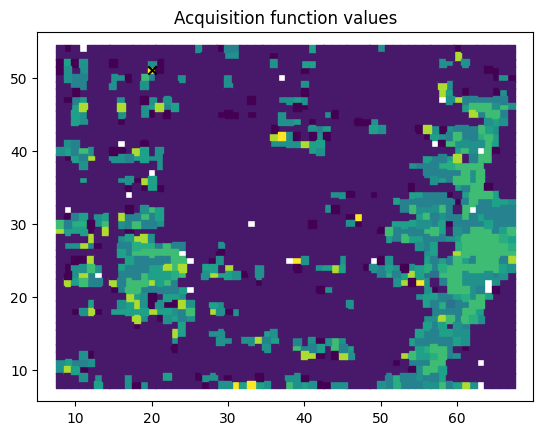

18/80


100%|██████████| 100/100 [00:01<00:00, 51.30it/s, init loss: 20146.5579, avg. loss [96-100]: 19063.0896]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31820000000000004
noise            0.07490000000000001


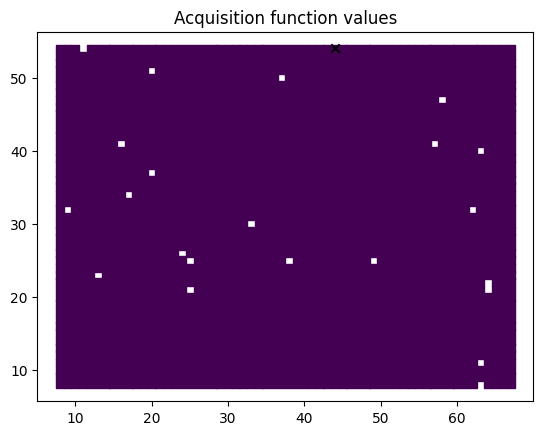

19/80


100%|██████████| 100/100 [00:02<00:00, 36.49it/s, init loss: 20147.7965, avg. loss [96-100]: 19063.2469]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.314
noise            0.0752


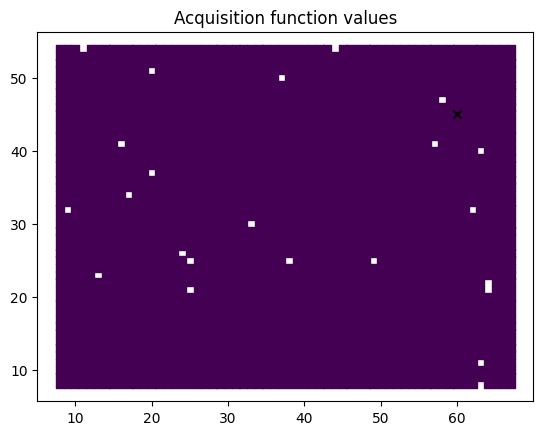

20/80


100%|██████████| 100/100 [00:02<00:00, 49.41it/s, init loss: 20148.9952, avg. loss [96-100]: 19063.2243]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31070000000000003
noise            0.0743


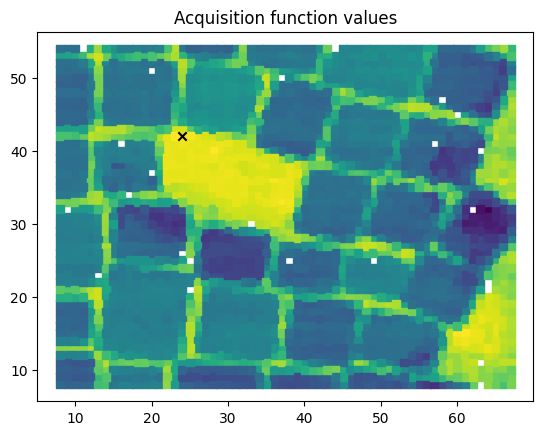

21/80


100%|██████████| 100/100 [00:01<00:00, 50.54it/s, init loss: 20150.2566, avg. loss [96-100]: 19063.0637]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3085
noise            0.0724


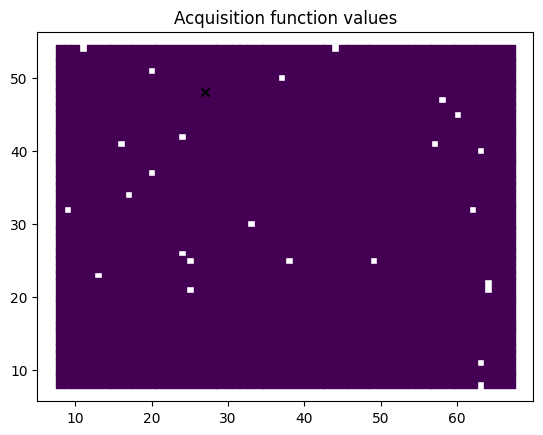

22/80


100%|██████████| 100/100 [00:01<00:00, 50.39it/s, init loss: 20151.4326, avg. loss [96-100]: 19062.9619]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3058
noise            0.0713


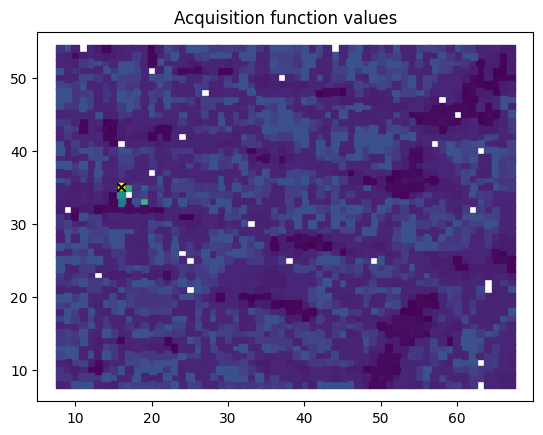

23/80


100%|██████████| 100/100 [00:01<00:00, 51.01it/s, init loss: 20152.8574, avg. loss [96-100]: 19063.7903]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.311
noise            0.0752


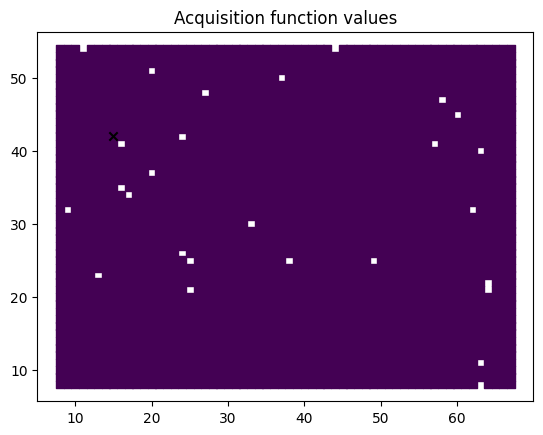

24/80


100%|██████████| 100/100 [00:02<00:00, 36.30it/s, init loss: 20154.0709, avg. loss [96-100]: 19081.2081]



Inferred GP kernel parameters
k_length         [1.9779 1.8286]
k_scale          0.22890000000000002
noise            0.0369


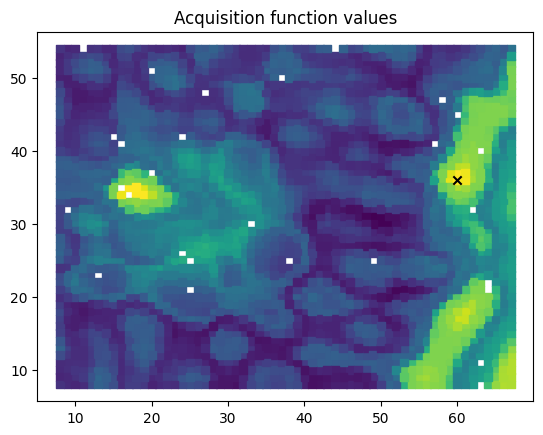

25/80


100%|██████████| 100/100 [00:02<00:00, 41.46it/s, init loss: 20155.4432, avg. loss [96-100]: 19063.9134]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3111
noise            0.0745


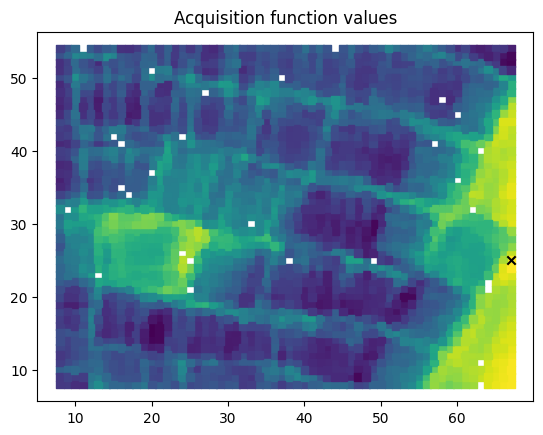

26/80


100%|██████████| 100/100 [00:01<00:00, 50.09it/s, init loss: 20156.6983, avg. loss [96-100]: 19063.7383]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3133
noise            0.0727


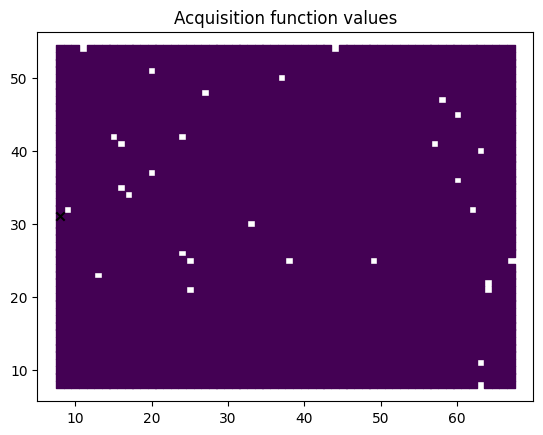

27/80


100%|██████████| 100/100 [00:02<00:00, 49.55it/s, init loss: 20157.9704, avg. loss [96-100]: 19085.3873]



Inferred GP kernel parameters
k_length         [3.0334 2.6268]
k_scale          0.2129
noise            0.030600000000000002


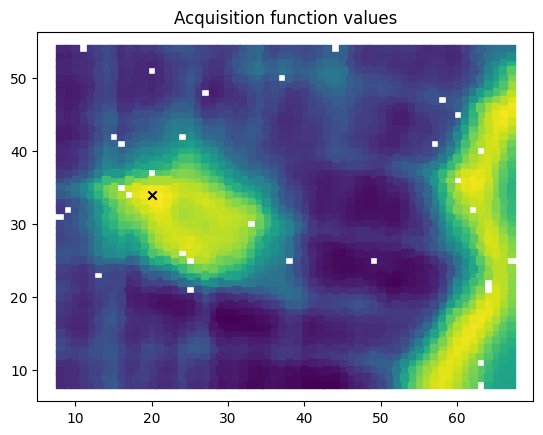

28/80


100%|██████████| 100/100 [00:01<00:00, 54.25it/s, init loss: 20159.2844, avg. loss [96-100]: 19095.6940]



Inferred GP kernel parameters
k_length         [2.459  2.7439]
k_scale          0.2028
noise            0.031


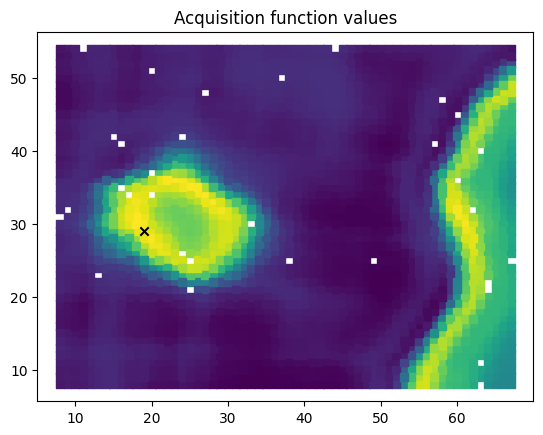

29/80


100%|██████████| 100/100 [00:02<00:00, 46.31it/s, init loss: 20160.5567, avg. loss [96-100]: 19115.5760]



Inferred GP kernel parameters
k_length         [3.7528 2.9273]
k_scale          0.20170000000000002
noise            0.0303


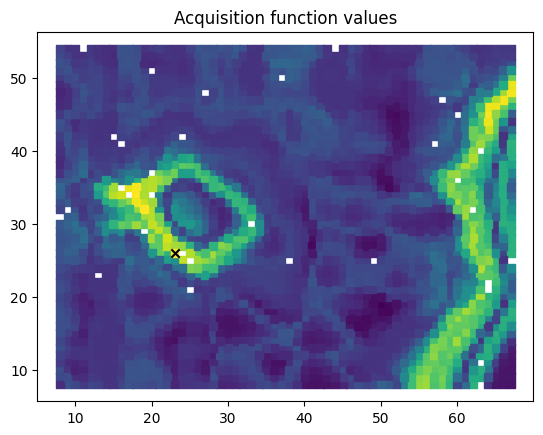

30/80


100%|██████████| 100/100 [00:02<00:00, 36.63it/s, init loss: 20161.9398, avg. loss [96-100]: 19101.6373]



Inferred GP kernel parameters
k_length         [2.3795 2.9021]
k_scale          0.2142
noise            0.0296


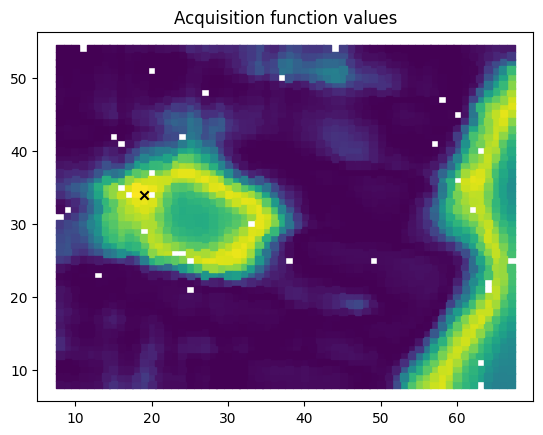

31/80


100%|██████████| 100/100 [00:02<00:00, 41.33it/s, init loss: 20163.1981, avg. loss [96-100]: 19065.1892]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3262
noise            0.0763


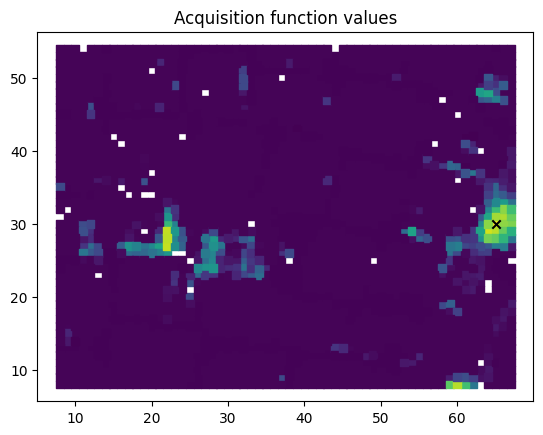

32/80


100%|██████████| 100/100 [00:01<00:00, 52.40it/s, init loss: 20164.5219, avg. loss [96-100]: 19093.3282]



Inferred GP kernel parameters
k_length         [3.7194 3.0548]
k_scale          0.1917
noise            0.0245


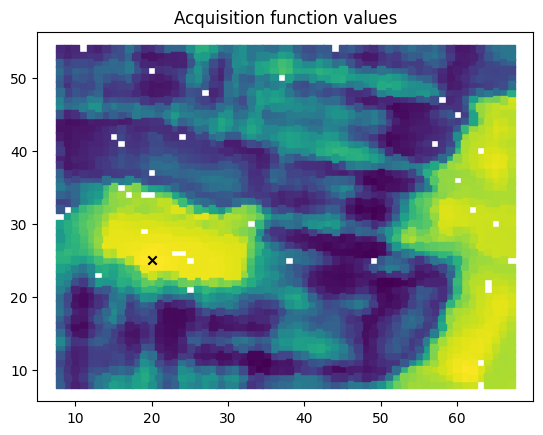

33/80


100%|██████████| 100/100 [00:01<00:00, 52.52it/s, init loss: 20165.9094, avg. loss [96-100]: 19108.6464]



Inferred GP kernel parameters
k_length         [2.8869 3.4307]
k_scale          0.2237
noise            0.0279


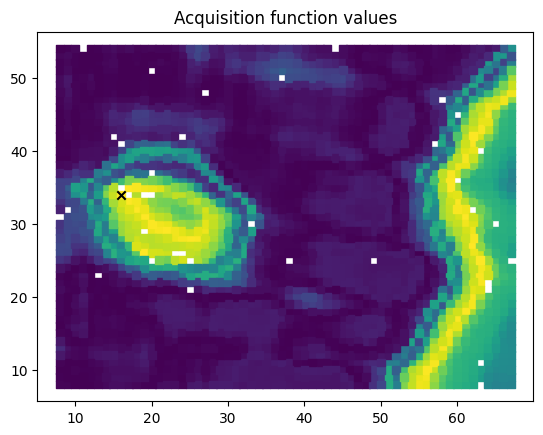

34/80


100%|██████████| 100/100 [00:01<00:00, 52.46it/s, init loss: 20167.2224, avg. loss [96-100]: 19083.8190]



Inferred GP kernel parameters
k_length         [3.3228 2.6326]
k_scale          0.22260000000000002
noise            0.0252


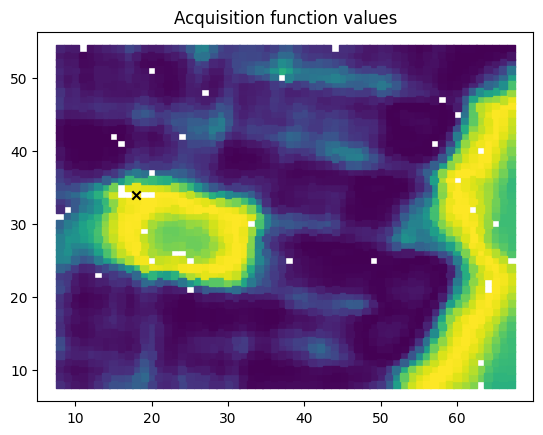

35/80


100%|██████████| 100/100 [00:02<00:00, 39.26it/s, init loss: 20168.4443, avg. loss [96-100]: 19100.7148]



Inferred GP kernel parameters
k_length         [2.1724 2.6117]
k_scale          0.22290000000000001
noise            0.0219


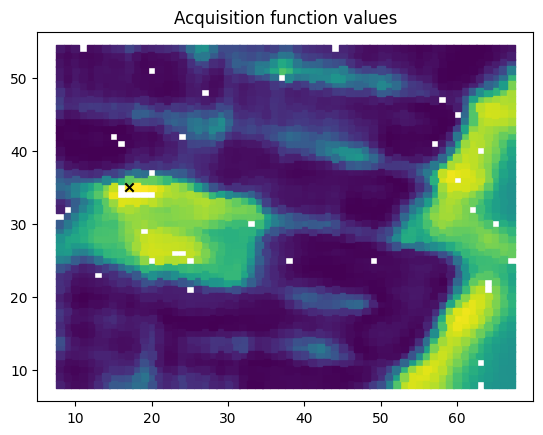

36/80


100%|██████████| 100/100 [00:02<00:00, 44.26it/s, init loss: 20169.7061, avg. loss [96-100]: 19077.1360]



Inferred GP kernel parameters
k_length         [2.7419 2.8495]
k_scale          0.2149
noise            0.0275


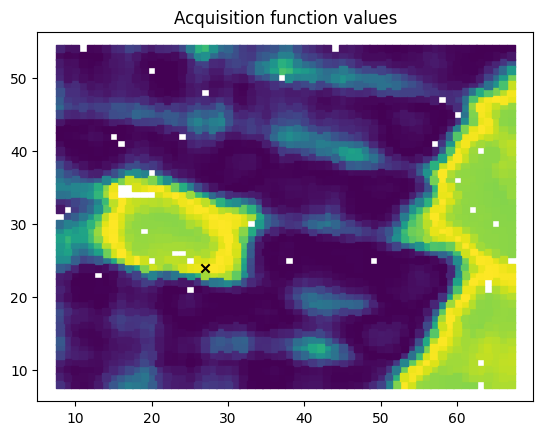

37/80


100%|██████████| 100/100 [00:01<00:00, 52.22it/s, init loss: 20171.0975, avg. loss [96-100]: 19123.9932]



Inferred GP kernel parameters
k_length         [5.1295 4.2581]
k_scale          0.1777
noise            0.028800000000000003


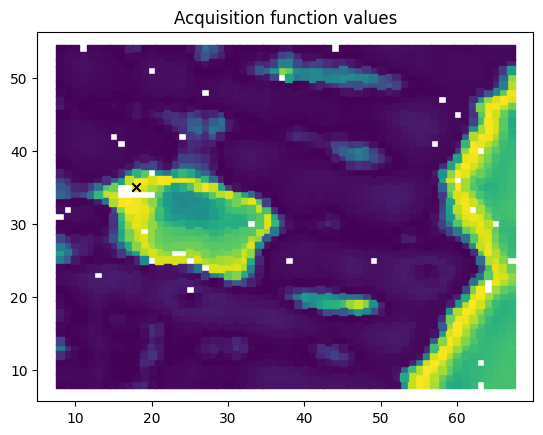

38/80


100%|██████████| 100/100 [00:01<00:00, 50.82it/s, init loss: 20172.2568, avg. loss [96-100]: 19096.5136]



Inferred GP kernel parameters
k_length         [3.9304 5.0548]
k_scale          0.20420000000000002
noise            0.026600000000000002


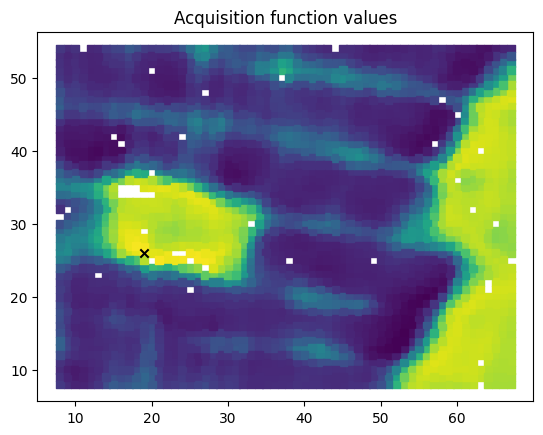

39/80


100%|██████████| 100/100 [00:01<00:00, 52.04it/s, init loss: 20173.4726, avg. loss [96-100]: 19063.9345]



Inferred GP kernel parameters
k_length         [3.3255 3.1905]
k_scale          0.2142
noise            0.0194


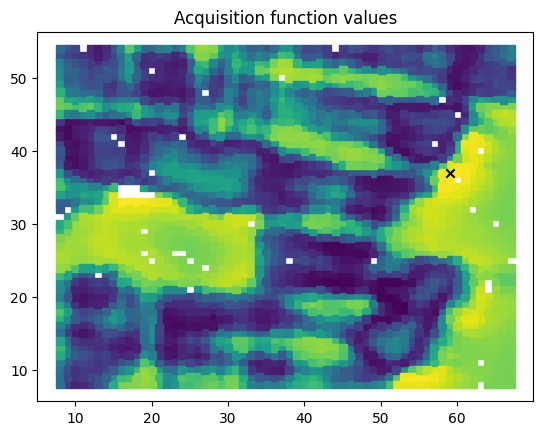

40/80


100%|██████████| 100/100 [00:01<00:00, 50.38it/s, init loss: 20174.7750, avg. loss [96-100]: 19086.6650]



Inferred GP kernel parameters
k_length         [3.7884 3.8581]
k_scale          0.21430000000000002
noise            0.022600000000000002


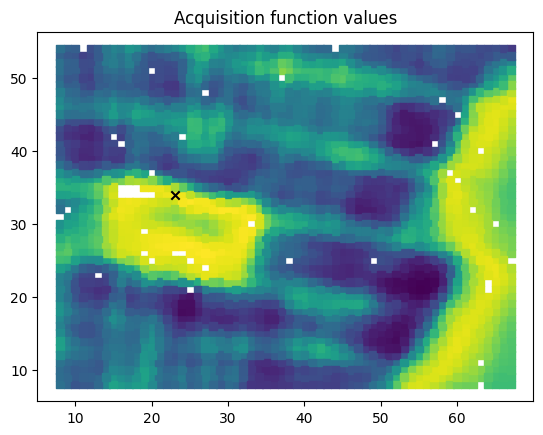

41/80


100%|██████████| 100/100 [00:02<00:00, 46.45it/s, init loss: 20176.1924, avg. loss [96-100]: 19053.9279]



Inferred GP kernel parameters
k_length         [2.7742 4.8556]
k_scale          0.228
noise            0.0213


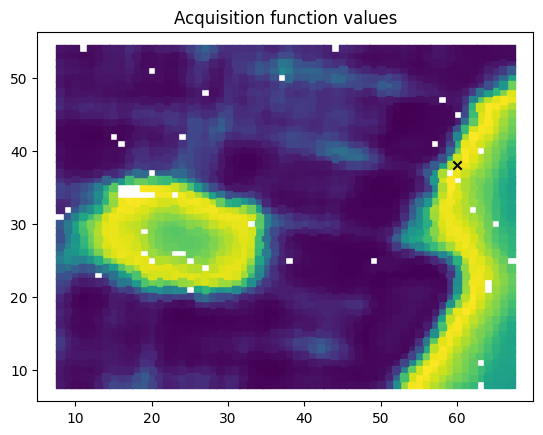

42/80


100%|██████████| 100/100 [00:02<00:00, 34.33it/s, init loss: 20177.5891, avg. loss [96-100]: 19127.4678]



Inferred GP kernel parameters
k_length         [6.3874 5.8217]
k_scale          0.20650000000000002
noise            0.0258


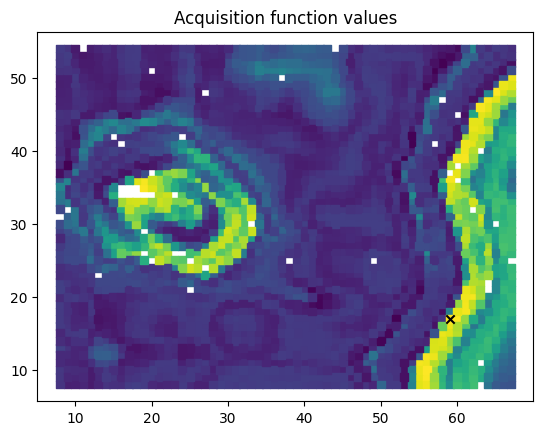

43/80


100%|██████████| 100/100 [00:01<00:00, 50.52it/s, init loss: 20178.9856, avg. loss [96-100]: 19071.4264]



Inferred GP kernel parameters
k_length         [4.7207 3.8601]
k_scale          0.21000000000000002
noise            0.0213


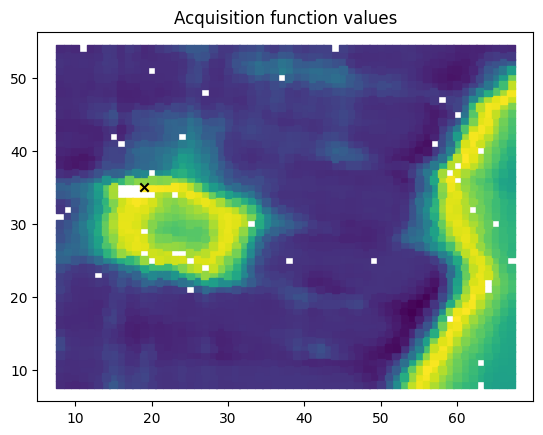

44/80


100%|██████████| 100/100 [00:01<00:00, 51.79it/s, init loss: 20180.1258, avg. loss [96-100]: 19069.0672]



Inferred GP kernel parameters
k_length         [5.271  2.8717]
k_scale          0.2082
noise            0.0212


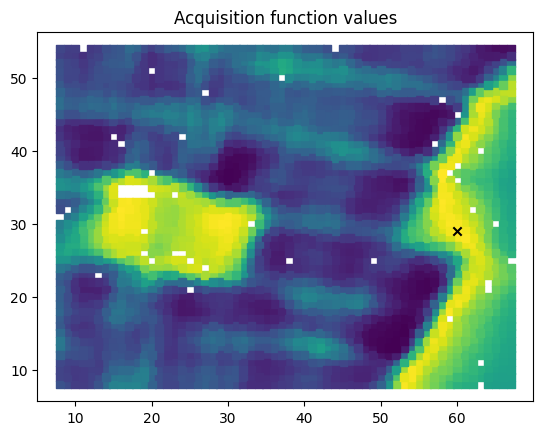

45/80


100%|██████████| 100/100 [00:02<00:00, 49.93it/s, init loss: 20181.4076, avg. loss [96-100]: 19139.0477]



Inferred GP kernel parameters
k_length         [4.5447 6.8321]
k_scale          0.21380000000000002
noise            0.0229


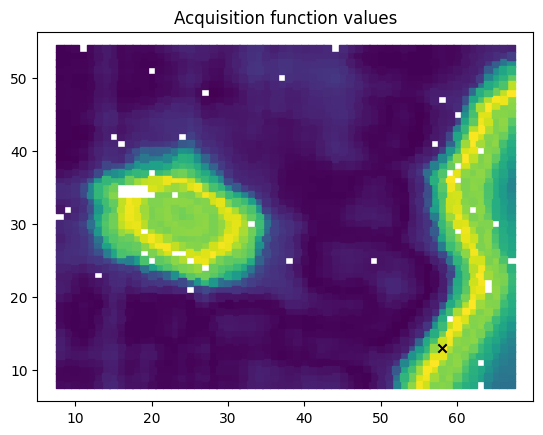

46/80


100%|██████████| 100/100 [00:01<00:00, 50.52it/s, init loss: 20182.7588, avg. loss [96-100]: 19114.4475]



Inferred GP kernel parameters
k_length         [3.2686 3.0104]
k_scale          0.2388
noise            0.020300000000000002


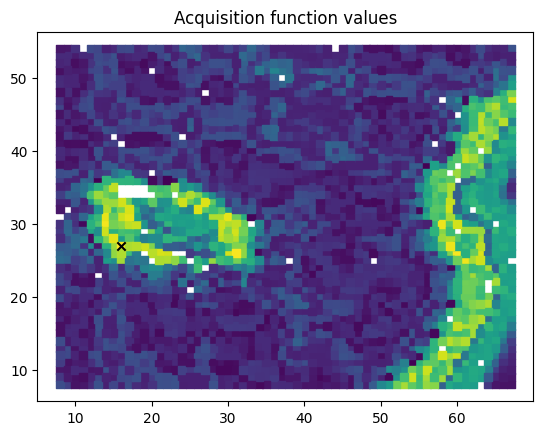

47/80


100%|██████████| 100/100 [00:01<00:00, 51.46it/s, init loss: 20183.9284, avg. loss [96-100]: 19148.5537]



Inferred GP kernel parameters
k_length         [4.2335 6.8176]
k_scale          0.24760000000000001
noise            0.0273


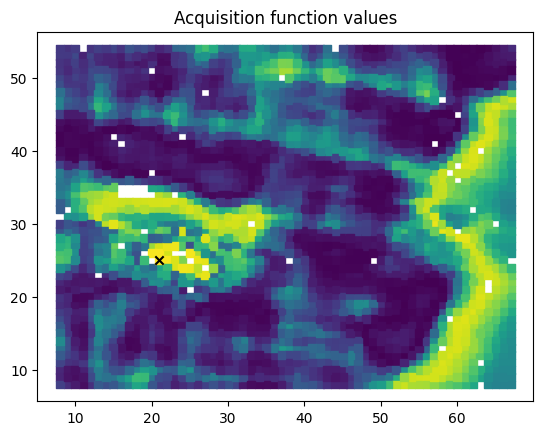

48/80


100%|██████████| 100/100 [00:02<00:00, 43.00it/s, init loss: 20185.2457, avg. loss [96-100]: 19066.5834]



Inferred GP kernel parameters
k_length         [3.7434 5.2152]
k_scale          0.2084
noise            0.0195


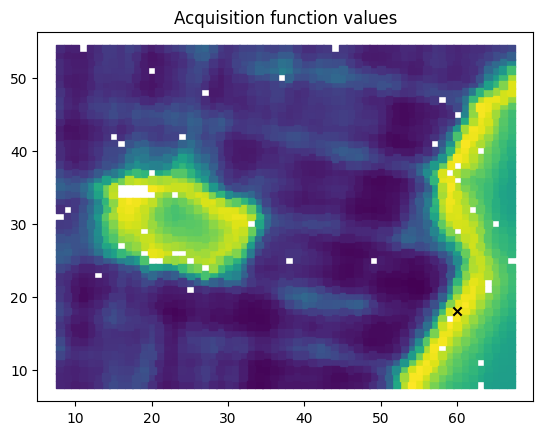

49/80


100%|██████████| 100/100 [00:02<00:00, 33.54it/s, init loss: 20186.5392, avg. loss [96-100]: 19088.1557]



Inferred GP kernel parameters
k_length         [6.6706 5.1371]
k_scale          0.2059
noise            0.0205


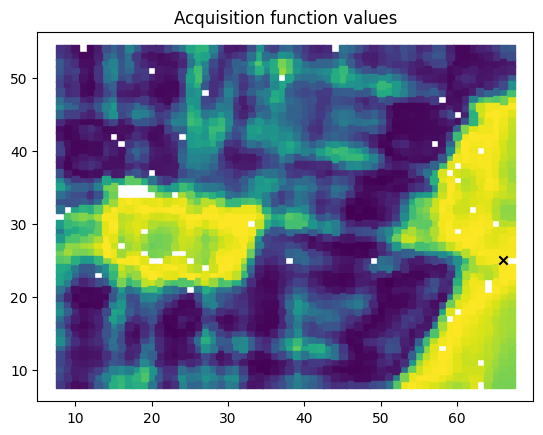

50/80


100%|██████████| 100/100 [00:02<00:00, 49.95it/s, init loss: 20187.7204, avg. loss [96-100]: 19125.0979]



Inferred GP kernel parameters
k_length         [4.3229 4.3011]
k_scale          0.2227
noise            0.0188


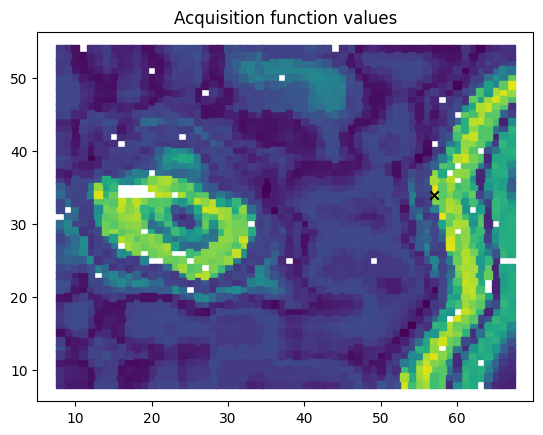

51/80


100%|██████████| 100/100 [00:01<00:00, 50.42it/s, init loss: 20188.9255, avg. loss [96-100]: 19103.4607]



Inferred GP kernel parameters
k_length         [4.2461 5.1769]
k_scale          0.19210000000000002
noise            0.0227


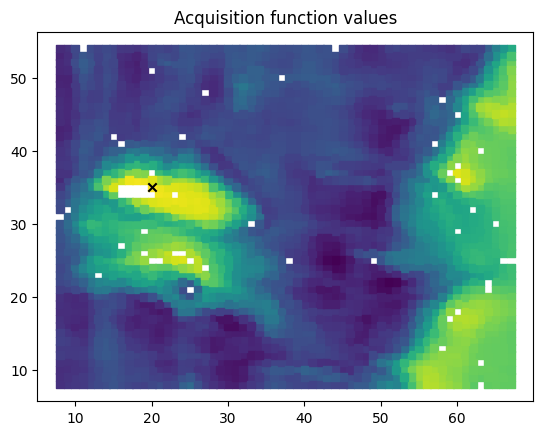

52/80


100%|██████████| 100/100 [00:01<00:00, 50.42it/s, init loss: 20190.2528, avg. loss [96-100]: 19084.1780]



Inferred GP kernel parameters
k_length         [5.2095 3.9844]
k_scale          0.21610000000000001
noise            0.02


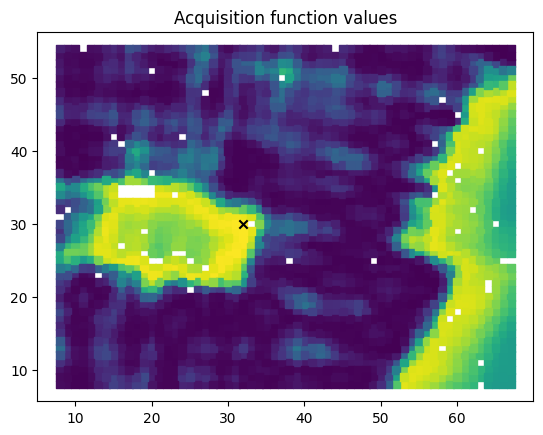

53/80


100%|██████████| 100/100 [00:01<00:00, 50.25it/s, init loss: 20191.4343, avg. loss [96-100]: 19043.1110]



Inferred GP kernel parameters
k_length         [4.1462 4.7725]
k_scale          0.2265
noise            0.0181


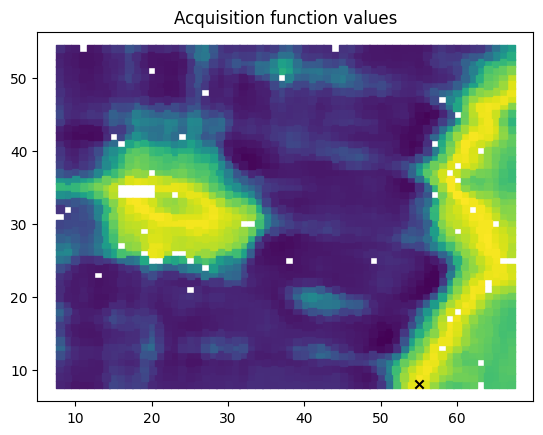

54/80


100%|██████████| 100/100 [00:01<00:00, 50.31it/s, init loss: 20192.7448, avg. loss [96-100]: 19095.6523]



Inferred GP kernel parameters
k_length         [6.1839 5.5285]
k_scale          0.1883
noise            0.0205


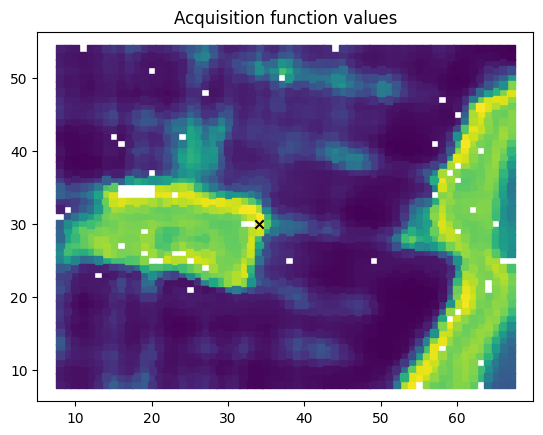

55/80


100%|██████████| 100/100 [00:01<00:00, 50.75it/s, init loss: 20193.9693, avg. loss [96-100]: 19069.7525]



Inferred GP kernel parameters
k_length         [2.5586 3.1089]
k_scale          0.25520000000000004
noise            0.0166


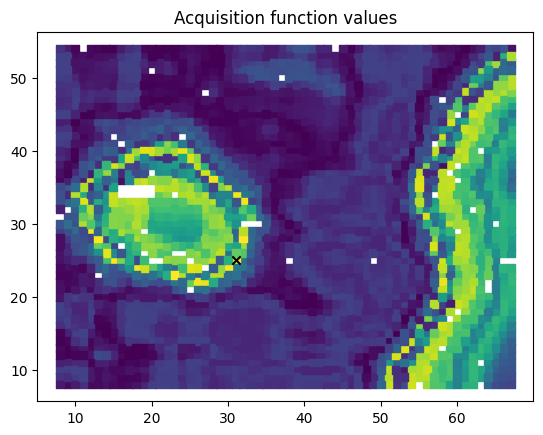

56/80


100%|██████████| 100/100 [00:02<00:00, 49.95it/s, init loss: 20195.3768, avg. loss [96-100]: 19107.3972]



Inferred GP kernel parameters
k_length         [4.6646 4.2773]
k_scale          0.20770000000000002
noise            0.0171


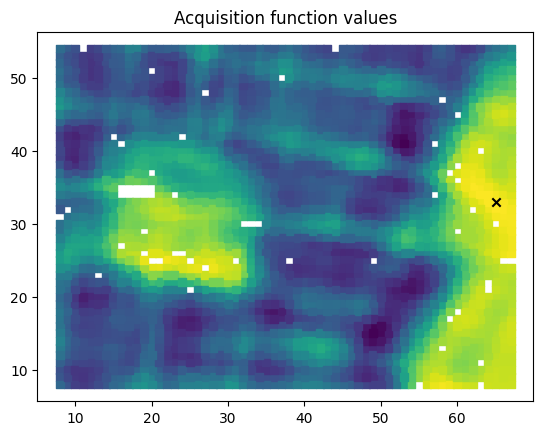

57/80


100%|██████████| 100/100 [00:02<00:00, 37.94it/s, init loss: 20196.6033, avg. loss [96-100]: 19119.7176]



Inferred GP kernel parameters
k_length         [5.1813 5.2879]
k_scale          0.19490000000000002
noise            0.0221


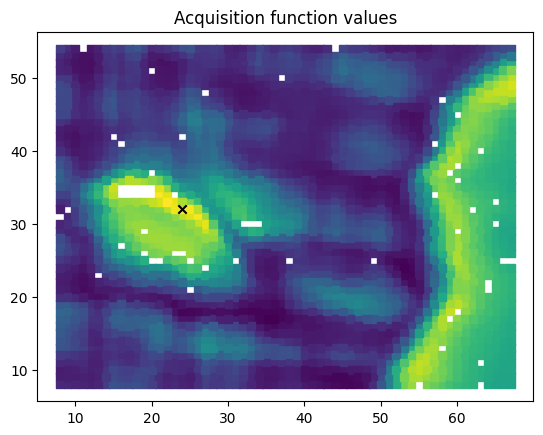

58/80


100%|██████████| 100/100 [00:02<00:00, 38.41it/s, init loss: 20197.7778, avg. loss [96-100]: 19048.2023]



Inferred GP kernel parameters
k_length         [4.371  5.6654]
k_scale          0.2121
noise            0.0193


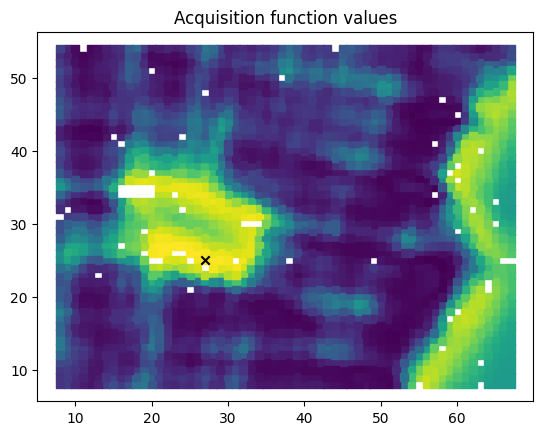

59/80


100%|██████████| 100/100 [00:01<00:00, 50.71it/s, init loss: 20199.0894, avg. loss [96-100]: 19058.1003]



Inferred GP kernel parameters
k_length         [5.1913 5.8502]
k_scale          0.194
noise            0.0205


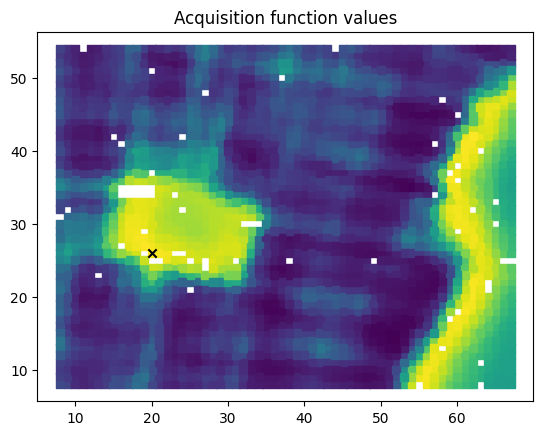

60/80


100%|██████████| 100/100 [00:02<00:00, 46.58it/s, init loss: 20200.2441, avg. loss [96-100]: 19156.8123]



Inferred GP kernel parameters
k_length         [6.968  7.9119]
k_scale          0.1971
noise            0.020900000000000002


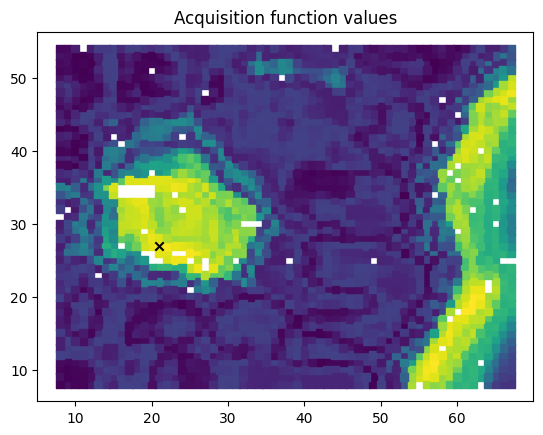

61/80


100%|██████████| 100/100 [00:02<00:00, 36.23it/s, init loss: 20201.4512, avg. loss [96-100]: 19082.6580]



Inferred GP kernel parameters
k_length         [8.7505 4.3136]
k_scale          0.19
noise            0.018000000000000002


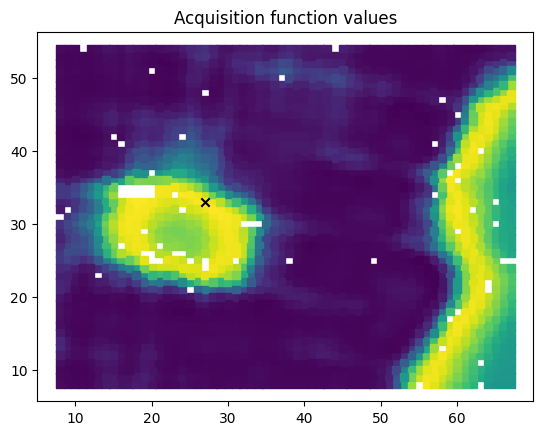

62/80


100%|██████████| 100/100 [00:02<00:00, 48.69it/s, init loss: 20202.8726, avg. loss [96-100]: 19037.8393]



Inferred GP kernel parameters
k_length         [5.1072 5.4312]
k_scale          0.21960000000000002
noise            0.016800000000000002


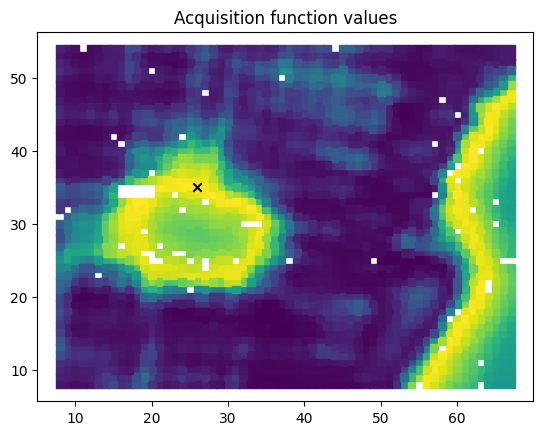

63/80


100%|██████████| 100/100 [00:02<00:00, 48.69it/s, init loss: 20204.0460, avg. loss [96-100]: 19055.6851]



Inferred GP kernel parameters
k_length         [6.2423 5.3654]
k_scale          0.2054
noise            0.0198


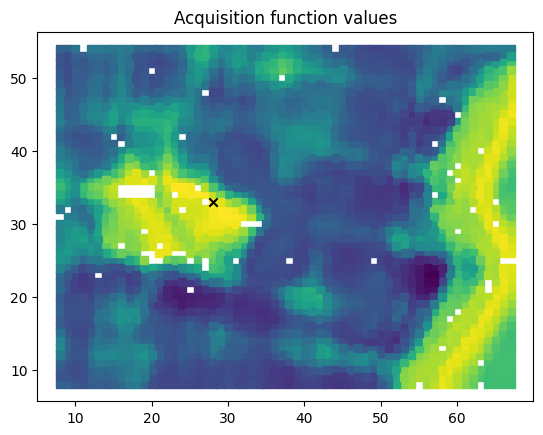

64/80


100%|██████████| 100/100 [00:02<00:00, 49.87it/s, init loss: 20205.2887, avg. loss [96-100]: 19083.6454]



Inferred GP kernel parameters
k_length         [7.4894 5.5901]
k_scale          0.1865
noise            0.0187


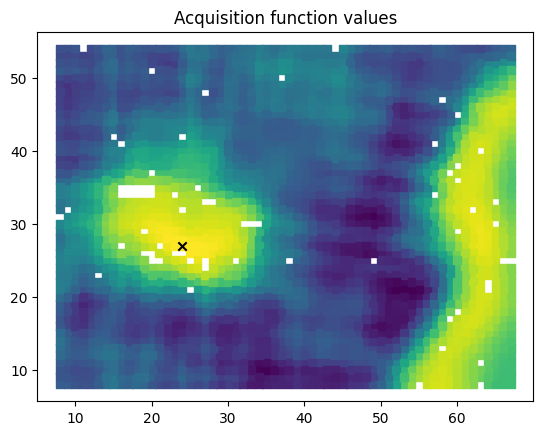

65/80


100%|██████████| 100/100 [00:02<00:00, 48.94it/s, init loss: 20206.6006, avg. loss [96-100]: 19063.5067]



Inferred GP kernel parameters
k_length         [4.5201 3.9275]
k_scale          0.1837
noise            0.0178


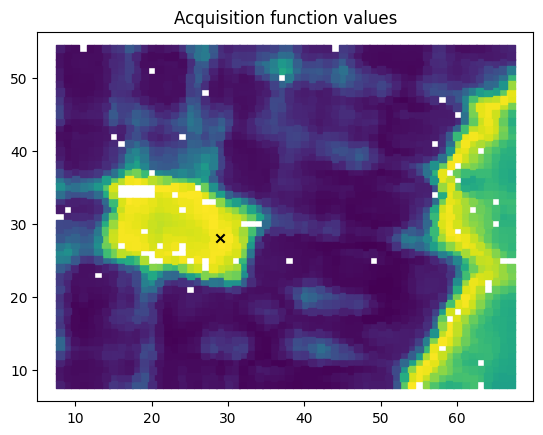

66/80


100%|██████████| 100/100 [00:02<00:00, 41.12it/s, init loss: 20207.9528, avg. loss [96-100]: 19080.1202]



Inferred GP kernel parameters
k_length         [4.0474 3.0791]
k_scale          0.2411
noise            0.0158


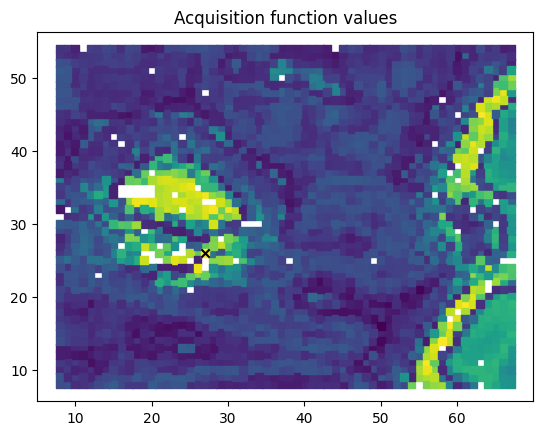

67/80


100%|██████████| 100/100 [00:02<00:00, 33.46it/s, init loss: 20209.2682, avg. loss [96-100]: 19069.6170]



Inferred GP kernel parameters
k_length         [7.3229 5.5319]
k_scale          0.2104
noise            0.019200000000000002


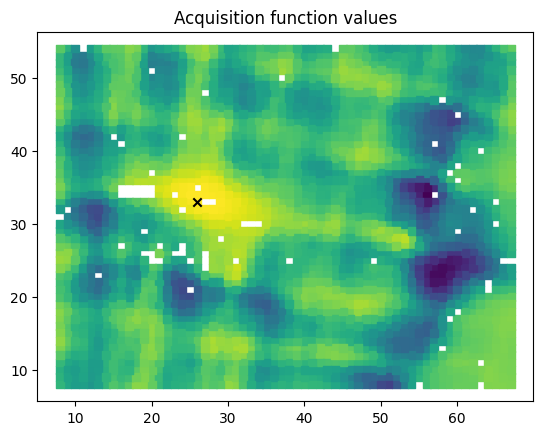

68/80


100%|██████████| 100/100 [00:02<00:00, 37.05it/s, init loss: 20210.5682, avg. loss [96-100]: 19078.3844]



Inferred GP kernel parameters
k_length         [7.9043 5.6079]
k_scale          0.21080000000000002
noise            0.0182


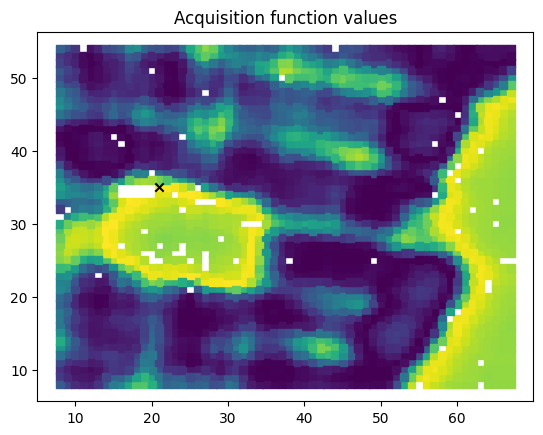

69/80


100%|██████████| 100/100 [00:02<00:00, 48.97it/s, init loss: 20211.9399, avg. loss [96-100]: 19090.8413]



Inferred GP kernel parameters
k_length         [6.6821 5.712 ]
k_scale          0.227
noise            0.017


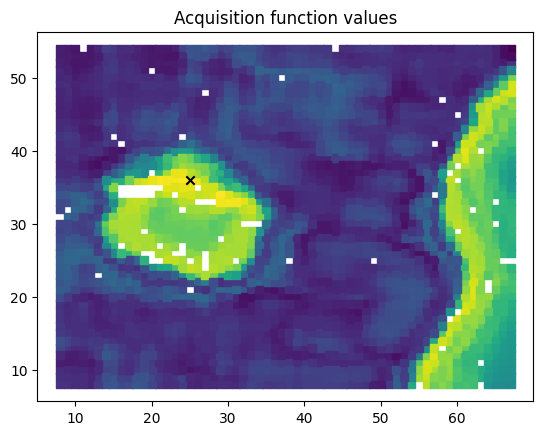

70/80


100%|██████████| 100/100 [00:02<00:00, 34.81it/s, init loss: 20213.2485, avg. loss [96-100]: 19067.3250]



Inferred GP kernel parameters
k_length         [6.6595 4.9442]
k_scale          0.20270000000000002
noise            0.0175


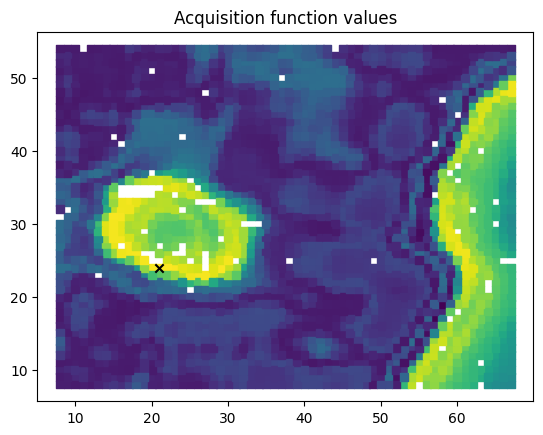

71/80


100%|██████████| 100/100 [00:02<00:00, 48.26it/s, init loss: 20214.4512, avg. loss [96-100]: 19103.8039]



Inferred GP kernel parameters
k_length         [4.0743 4.8343]
k_scale          0.22410000000000002
noise            0.0188


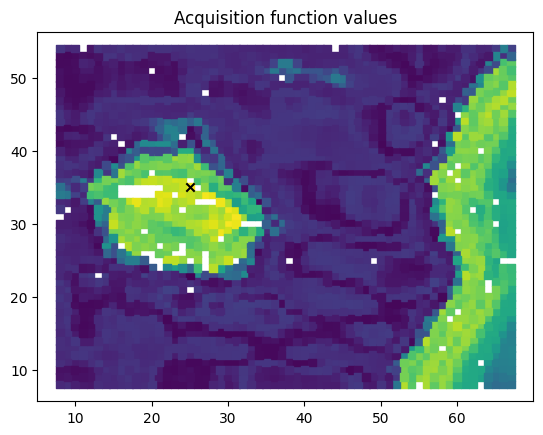

72/80


100%|██████████| 100/100 [00:02<00:00, 48.96it/s, init loss: 20215.7908, avg. loss [96-100]: 19085.0870]



Inferred GP kernel parameters
k_length         [6.9044 7.1917]
k_scale          0.20550000000000002
noise            0.021


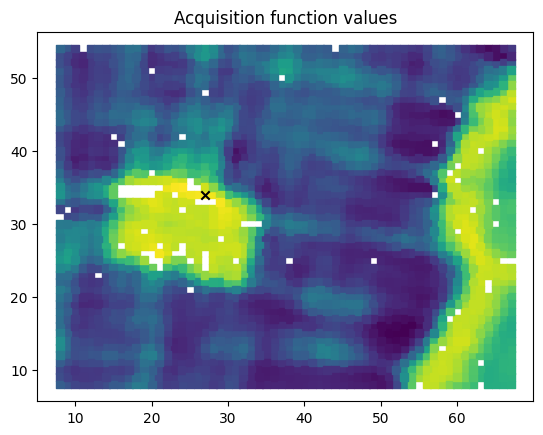

73/80


100%|██████████| 100/100 [00:02<00:00, 48.88it/s, init loss: 20217.0866, avg. loss [96-100]: 19123.1502]



Inferred GP kernel parameters
k_length         [9.6074 7.851 ]
k_scale          0.195
noise            0.018600000000000002


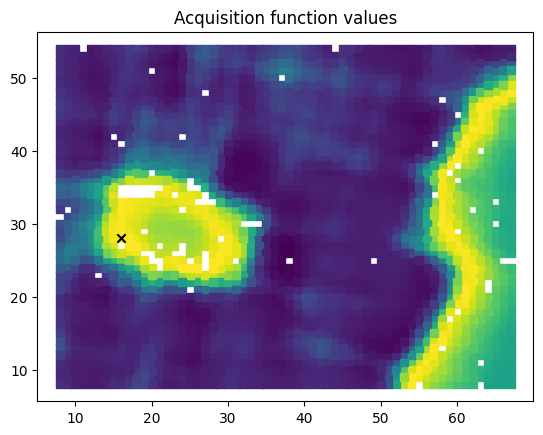

74/80


100%|██████████| 100/100 [00:02<00:00, 49.36it/s, init loss: 20218.3177, avg. loss [96-100]: 19146.2812]



Inferred GP kernel parameters
k_length         [8.1637 6.6571]
k_scale          0.1839
noise            0.02


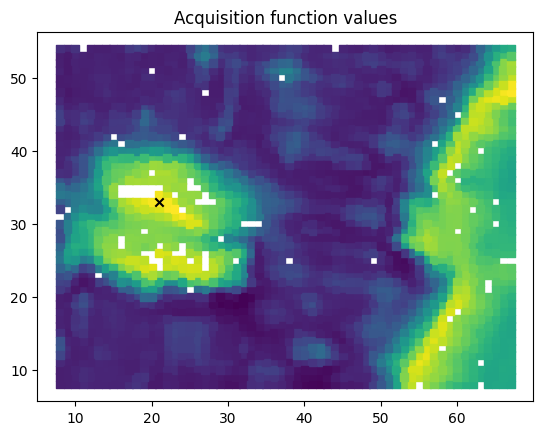

75/80


100%|██████████| 100/100 [00:02<00:00, 48.95it/s, init loss: 20219.7260, avg. loss [96-100]: 19055.8235]



Inferred GP kernel parameters
k_length         [6.713 4.556]
k_scale          0.1971
noise            0.0176


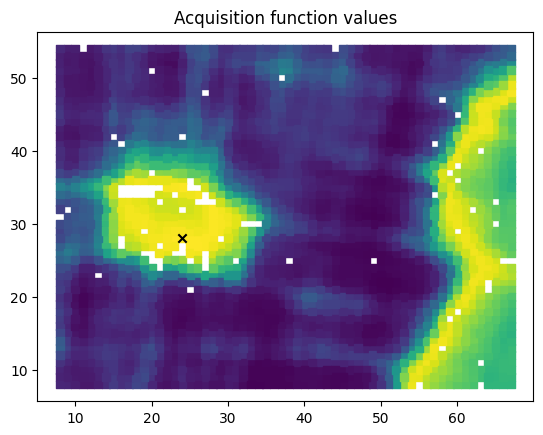

76/80


100%|██████████| 100/100 [00:02<00:00, 47.14it/s, init loss: 20220.8522, avg. loss [96-100]: 19089.9200]



Inferred GP kernel parameters
k_length         [ 8.3083 10.0182]
k_scale          0.2351
noise            0.018000000000000002


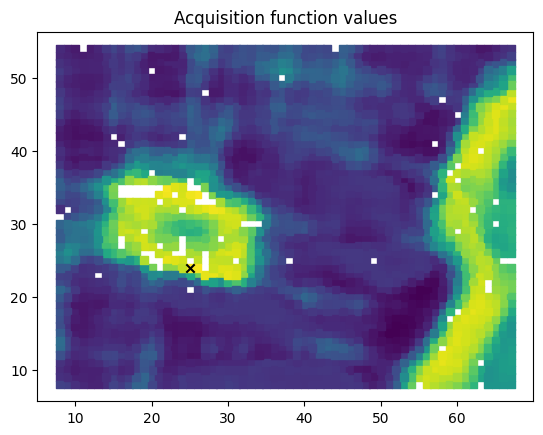

77/80


100%|██████████| 100/100 [00:03<00:00, 32.72it/s, init loss: 20222.2222, avg. loss [96-100]: 19042.7228]



Inferred GP kernel parameters
k_length         [6.1162 7.3489]
k_scale          0.22060000000000002
noise            0.0184


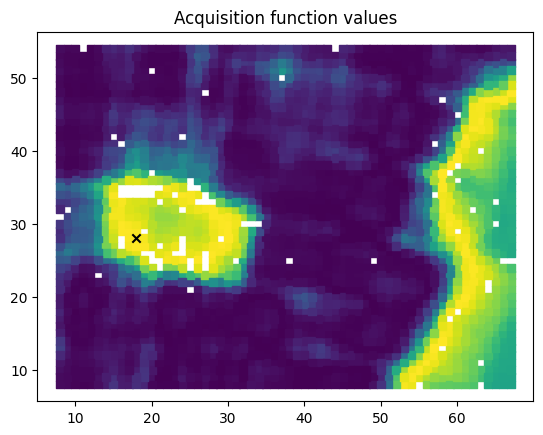

78/80


100%|██████████| 100/100 [00:02<00:00, 38.47it/s, init loss: 20223.4835, avg. loss [96-100]: 19056.1033]



Inferred GP kernel parameters
k_length         [5.8343 6.4305]
k_scale          0.1864
noise            0.0167


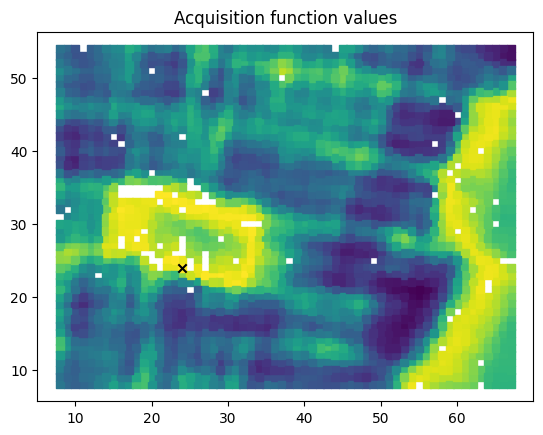

79/80


100%|██████████| 100/100 [00:02<00:00, 49.07it/s, init loss: 20224.7446, avg. loss [96-100]: 19138.0478]



Inferred GP kernel parameters
k_length         [13.5691 11.4752]
k_scale          0.18760000000000002
noise            0.020300000000000002


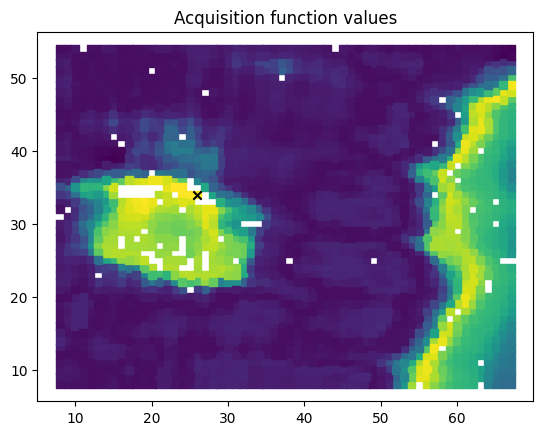

80/80


100%|██████████| 100/100 [00:03<00:00, 33.18it/s, init loss: 20225.9605, avg. loss [96-100]: 19122.0123]



Inferred GP kernel parameters
k_length         [10.1919 10.7863]
k_scale          0.1945
noise            0.020300000000000002


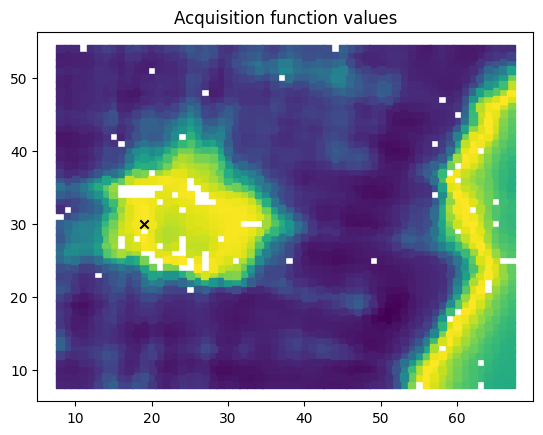

In [ ]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=32, c=obj, marker='s')
    next_point = indices[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_measured.shape[-1]

exploration_steps = 80

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(  # you may decrease step size and increase number of steps (e.g. to 0.005 and 1000) for more stable performance
        key1, X_measured, y_measured, num_steps=100, step_size=0.05)
    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_unmeasured, beta=0.25, maximize=True)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    # Do "measurement"
    measured_point = y_unmeasured[next_point_idx]
    # Plot current result
    plot_result(indices_unmeasured, obj)
    # Update the arrays of measured/unmeasured points
    X_measured = np.append(X_measured, X_unmeasured[next_point_idx][None], 0)
    X_unmeasured = np.delete(X_unmeasured, next_point_idx, 0)
    y_measured = np.append(y_measured, measured_point)
    y_unmeasured = np.delete(y_unmeasured, next_point_idx)
    indices_measured = np.append(indices_measured, indices_unmeasured[next_point_idx][None], 0)
    indices_unmeasured = np.delete(indices_unmeasured, next_point_idx, 0)

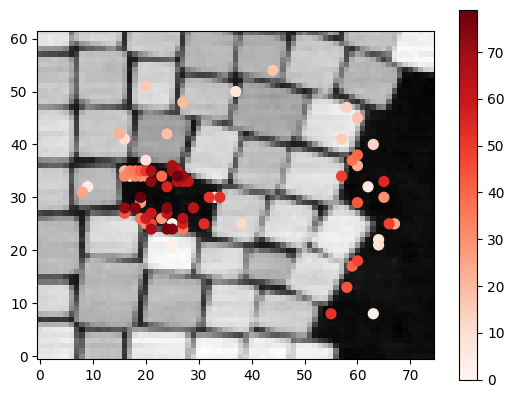

In [ ]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_measured[seed_points:, 1], indices_measured[seed_points:, 0],
            c=np.arange(len(indices_measured[seed_points:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

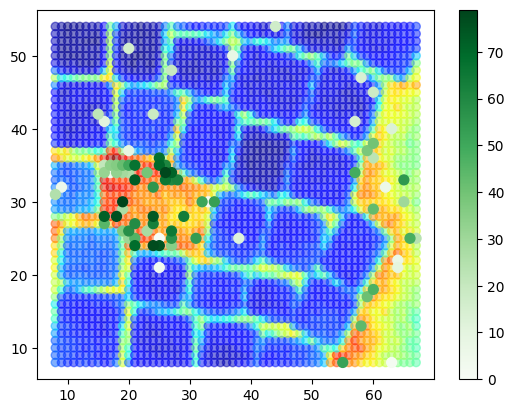

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_measured[seed_points:, 1], indices_measured[seed_points:, 0],
            c=np.arange(len(indices_measured[seed_points:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of interest is maximized!

As possible experiments:
- try to make your own scalarizer function (e.g. intensity within a certain band) and see how results change
- Play wth the acquisition function parameters (e.g. vary the exploration vs. exploitation balance)
- And try it on own data! Just keep the shape and type of the variables as they are, and enjoy the experiments.

To date, our group has implemented the DKL based workflows for STEM-EELS and 4D STEM in electron microscopy, and hysteresis loop measurements and nonlineariy measurements in scanning probe microscopy. We have also implemented the versions of DKL with multiple input channels (the version of the hypothesis learning) where algorithm seeks ot discover best predictive channel. You can read about it more:

- DKL STEM EELS: https://onlinelibrary.wiley.com/doi/full/10.1002/advs.202203422 and https://arxiv.org/abs/2108.03290
- DKL 4D STEM: https://pubs.acs.org/doi/abs/10.1021/acsnano.1c11118 and https://arxiv.org/abs/2112.04479

- DKL PFM hysteresis: https://www.nature.com/articles/s42256-022-00460-0 and https://arxiv.org/abs/2108.06037
- DKL PFM non-linearity: https://onlinelibrary.wiley.com/doi/abs/10.1002/smll.202204130 and https://arxiv.org/abs/2207.03039 
- DKL PFM channel selection: https://www.nature.com/articles/s41524-023-00985-x and https://arxiv.org/abs/2206.15110
- Channel selection:  https://arxiv.org/abs/2203.10181

- DKL IV SPM: https://pubs.acs.org/doi/10.1021/acs.jpclett.3c00223 and https://arxiv.org/abs/2212.07310
